In [49]:
%matplotlib inline
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,MaxPooling2D
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input
from glob import glob
from itertools import cycle,zip_longest
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import json
import time
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import lda
import collections
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

## Data Processing - Create Batch Generator

In [2]:
#run extract_files.py to process the image files
total_image_number = 206900

## Process .json file with image labels 

In [3]:
def process_label_file():
    #with open("photos.json") as infile:
    with open("../photos.json") as infile:
      val = infile.readlines()

    id = []
    label = []
    for i in val:
      #print(i)
      #print("ID: %s, Label: %s" % (json.loads(i)['photo_id'],json.loads(i)['label']))
      id.append(json.loads(i)['photo_id'])
      label.append(json.loads(i)['label'])
    id = np.asarray(id)
    label = np.asarray(label)
    info = np.vstack((id,label))
    info = info.T
    info[0,:]
    return info

In [4]:
#align images with labels in used_im_labels array
def map_label_file_to_names(json_labels,names):
    process_names = names
    new_names = [(name.replace("/home/ubuntu/project/le49/photos/","")).replace(".jpg","") for name in process_names]
    used_im_labels = [json_labels[np.where(json_labels[:,0]==name)[0][0],1] for name in new_names]
    return np.asarray(used_im_labels)

In [5]:
info = process_label_file()

In [6]:
#data is saved, uncomment if need to re-generate
#used_im_labels = map_label_file_to_names(info,names)
#np.save('labels.npy', used_im_labels) 

In [7]:
used_im_labels = np.load('labels.npy')

In [8]:
#unique elements in json file i.e. food, drink, inside, outside and menu
uniq_elem = np.unique(info[:,1])

## Define Model

In [9]:
# refer to extract_files.py for model definiton

## Load Extracted Features
These are extracted using extract_files.py and saved into .npy files for speed

In [10]:
#refer to extract_files.py for creation of these files
names = np.load('names.npy')

In [11]:
final_features_b2_av = np.load('predictions_block2_global.npy')

In [12]:
final_features_b5_av = np.load('predictions_block5_global.npy')

In [13]:
final_features_b2_max = np.load('predictions_block2_max.npy')

In [14]:
final_features_b5_max = np.load('predictions_block5_max.npy')

## Process features into word representations

** Process by normalising the rows and setting values > 0.5 to 1 otherwise 0 **

In [15]:
def process_features_with_normalising(final_features):
    processed_features_list = []
    mean = np.mean(final_features,axis=1)
    min = np.min(final_features,axis=1)
    max = np.max(final_features,axis=1)
    for row in range(final_features.shape[0]):
      if((100*row/final_features.shape[0]) % 10 == 0 and int(100*row/final_features.shape[0]) !=0):
          print("%s" % (int(100*row/final_features.shape[0])))
      normalised_row = [(image-min[row])/(max[row]-min[row]) for image in final_features[row,:]]
      discrete_row = [1 if image >= 0.5 else 0 for image in normalised_row]
      final_array_row = np.asarray(discrete_row)
      processed_features_list.append(final_array_row)
    return np.asarray(processed_features_list)

In [16]:
#data is saved, uncomment if need to re-run
#processed_features_b5_av_norm = process_features_with_normalising(final_features_b5_av)
#processed_features_b5_max_norm = process_features_with_normalising(final_features_b5_max)
#processed_features_b2_av_norm = process_features_with_normalising(final_features_b2_av)
#processed_features_b2_max_norm = process_features_with_normalising(final_features_b2_max)

In [17]:
#np.save('processed_features_b5_av_norm.npy', processed_features_b5_av_norm) 
#np.save('processed_features_b5_max_norm.npy', processed_features_b5_max_norm) 
#np.save('processed_features_b2_av_norm.npy', processed_features_b2_av_norm) 
#np.save('processed_features_b2_max_norm.npy', processed_features_b2_max_norm) 

In [18]:
#processed_features_b5_av_norm = np.load('processed_features_b5_av_norm.npy')
#processed_features_b5_max_norm = np.load('processed_features_b5_max_norm.npy')
#processed_features_b2_av_norm = np.load('processed_features_b2_av_norm.npy')
#processed_features_b2_max_norm = np.load('processed_features_b2_max_norm.npy')

In [19]:
def process_features_with_counts(final_features):
    num_features = final_features.shape[1]
    return np.reshape(np.round(np.reshape(final_features,(total_image_number*num_features))),(total_image_number,num_features)).astype(int)

In [20]:
#data is saved, uncomment if need to re-run
#processed_features_b5_av_counts = process_features_with_counts(final_features_b5_av)
#processed_features_b5_max_counts = process_features_with_counts(final_features_b5_max)
#processed_features_b2_av_counts = process_features_with_counts(final_features_b2_av)
#processed_features_b2_max_counts = process_features_with_counts(final_features_b2_max)

In [21]:
#np.save('processed_features_b5_av_counts.npy', processed_features_b5_av_counts) 
#np.save('processed_features_b5_max_counts.npy', processed_features_b5_max_counts) 
#np.save('processed_features_b2_av_counts.npy', processed_features_b2_av_counts) 
#np.save('processed_features_b2_max_counts.npy', processed_features_b2_max_counts) 

In [22]:
processed_features_b5_av_counts = np.load('processed_features_b5_av_counts.npy')
processed_features_b5_max_counts = np.load('processed_features_b5_max_counts.npy')
processed_features_b2_av_counts = np.load('processed_features_b2_av_counts.npy')
processed_features_b2_max_counts = np.load('processed_features_b2_max_counts.npy')

In [23]:
def regenerate_random_data_samples(total_samples,random_subset, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    final_subset = features[random_subset][0,:,:]
    final_labels = used_im_labels[random_subset][0]
    final_names = names[random_subset][0]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names


In [24]:
def generate_random_data_samples(total_samples, features):
    subset_samples = []
    subset_labels = []
    random_subset_vals = []
    names_subset = []
    random_subset = np.random.choice(range(0,processed_features.shape[0]), size=(total_samples), replace=False)
    final_subset = features[random_subset]
    final_labels = used_im_labels[random_subset]
    final_names = names[random_subset]
    random_subset_vals.append(random_subset)
    return final_subset, final_labels, random_subset_vals,final_names



In [25]:
#final_subset, final_labels, random_subset, names_subset= generate_random_data_samples(2000)

In [26]:
#to see the names of the files used refer to "names_of_data_files_used.txt"
random_subset = np.load("subset_test1.npy") #~1% data (same distribution)! 

** Define all features for the subset data samples for the different configurations **

In [27]:
final_subset_b5_av, final_labels, random_subset_val, names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_av_counts) # max 894


In [28]:
final_subset_b5_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b5_max_counts) # max 894



In [29]:
final_subset_b2_av, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_av_counts) # max 894 


In [30]:
final_subset_b2_max, final_labels, random_subset_val,names_subset = regenerate_random_data_samples(2000,random_subset,processed_features_b2_max_counts) # max 894 

## Do LDA on word representations

In [106]:
#alpha = 0.1 default
num_topics = 10

model_lda_b5_av_10 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_10.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_10.npy",model_lda_b5_av_10.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_10.npy",model_lda_b5_av_10.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_10.npy",model_lda_b5_av_10.ndz_)

model_lda_b2_av_10 = lda.LDA(n_topics=num_topics, n_iter=300, random_state=1)
model_lda_b2_av_10.fit(final_subset_b2_av)

np.save("./final_data/model_lda_b2_av_topic_c_10.npy",model_lda_b2_av_10.doc_topic_)
np.save("./final_data/model_lda_b2_av_comp_c_10.npy",model_lda_b2_av_10.components_)
np.save("./final_data/model_lda_b2_av_ndz_c_10.npy",model_lda_b2_av_10.ndz_)

model_lda_b5_max_10 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_max_10.fit(final_subset_b5_max)

np.save("./final_data/model_lda_b5_max_topic_c_10.npy",model_lda_b5_max_10.doc_topic_)
np.save("./final_data/model_lda_b5_max_comp_c_10.npy",model_lda_b5_max_10.components_)
np.save("./final_data/model_lda_b5_max_ndz_c_10.npy",model_lda_b5_max_10.ndz_)

num_topics = 5

model_lda_b5_av_5 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_5.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_5.npy",model_lda_b5_av_5.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_5.npy",model_lda_b5_av_5.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_5.npy",model_lda_b5_av_5.ndz_)

num_topics = 40

model_lda_b5_av_40 = lda.LDA(n_topics=num_topics, n_iter=150, random_state=1)
model_lda_b5_av_40.fit(final_subset_b5_av)

np.save("./final_data/model_lda_b5_av_topic_c_40.npy",model_lda_b5_av_40.doc_topic_)
np.save("./final_data/model_lda_b5_av_comp_c_40.npy",model_lda_b5_av_40.components_)
np.save("./final_data/model_lda_b5_av_ndz_c_40.npy",model_lda_b5_av_40.ndz_)

INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 512
INFO:lda:n_words: 1422359
INFO:lda:n_topics: 10
INFO:lda:n_iter: 150
INFO:lda:<0> log likelihood: -11825579
INFO:lda:<10> log likelihood: -10270070
INFO:lda:<20> log likelihood: -9505633
INFO:lda:<30> log likelihood: -9395627
INFO:lda:<40> log likelihood: -9366753
INFO:lda:<50> log likelihood: -9353794
INFO:lda:<60> log likelihood: -9340585
INFO:lda:<70> log likelihood: -9335543
INFO:lda:<80> log likelihood: -9331000
INFO:lda:<90> log likelihood: -9328905
INFO:lda:<100> log likelihood: -9324009
INFO:lda:<110> log likelihood: -9324179
INFO:lda:<120> log likelihood: -9324403
INFO:lda:<130> log likelihood: -9324002
INFO:lda:<140> log likelihood: -9320415
INFO:lda:<149> log likelihood: -9320639
INFO:lda:n_documents: 2000
INFO:lda:vocab_size: 128
INFO:lda:n_words: 33874886
INFO:lda:n_topics: 10
INFO:lda:n_iter: 300
INFO:lda:<0> log likelihood: -240159529
INFO:lda:<10> log likelihood: -239492664
INFO:lda:<20> log likelihood: -234599367
INFO

In [31]:
#use the model topic counts to recreate the posterior distribution by sampling from a dirichlet
def calculate_mean_std_dirichlet_distribution(model_ndz):
    results = np.zeros([1000,2000,model_ndz.shape[1]])
    for i in range(0,1000):
        for j in range(0,2000):
            results[i,j,:] = np.random.dirichlet(model_ndz[j,:]+0.1)
    return np.mean(results,axis=0),np.std(results,axis=0)

In [34]:
model = np.load("./final_data/model_lda_b5_av_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b2_av_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b5_max_ndz_c_10.npy")
#model = np.load("./final_data/model_lda_b5_av_ndz_c_5.npy")
#model = np.load("./final_data/model_lda_b5_av_ndz_c_40.npy")

In [35]:
std = np.reshape(calculate_mean_std_dirichlet_distribution(model)[1],(model.shape[0]*model.shape[1]))

(array([1.27782480e+02, 2.65684979e+01, 3.39310188e+01, 3.83430164e+01,
        3.15319951e+01, 1.39253673e+01, 3.06082331e+00, 4.13624772e-01,
        1.65449909e-01, 2.75749848e-02]),
 array([0.00015716, 0.00378364, 0.00741011, 0.01103659, 0.01466306,
        0.01828954, 0.02191601, 0.02554249, 0.02916896, 0.03279544,
        0.03642191]),
 <a list of 10 Patch objects>)

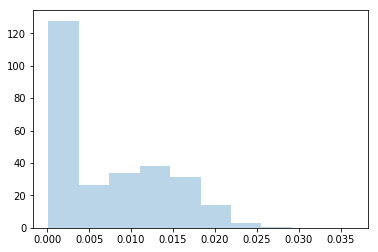

In [36]:
plt.hist(std,bins=10,alpha = 0.3,normed=True)

In [132]:
#np.save("./final_data/std_lda_b5_av_c_10.npy",std)
#np.save("./final_data/std_lda_b2_av_c_10.npy",std)
#np.save("./final_data/std_lda_b5_max_c_10.npy",std)
#np.save("./final_data/std_lda_b5_av_c_5.npy",std)
#np.save("./final_data/std_lda_b5_av_c_40.npy",std)

In [133]:
print(model_lda_b5_av_10.loglikelihood())
print(model_lda_b2_av_10.loglikelihood())
print(model_lda_b5_max_10.loglikelihood())
print(model_lda_b5_av_5.loglikelihood())
print(model_lda_b5_av_40.loglikelihood())

-9320639.49330952
-206291392.98282573
-213789558.9091874
-9052175.181839911
-9641497.959669007


** Plot Convergence of LDA **

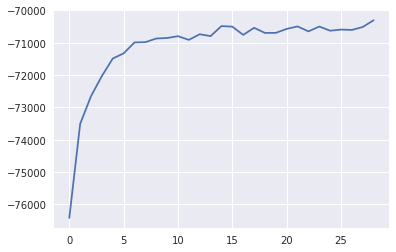

In [177]:
#using a chosen model
plt.plot(model_lda_b5_av.loglikelihoods_[1:])

** To compare the clustering of two models, use the adjusted rand score **

In [461]:
adjusted_rand_score(np.argmax(model_lda_b5_av.doc_topic_,axis=1),np.argmax(model_lda_b2_av.doc_topic_,axis=1))

0.04802338540627367

## Visualisation of LDA wrt image labels

In [ ]:
def save_tsne_plot_as_txt(tsne_low_dim_rep,labels,fname):
    with open(fname, 'w') as f:
          f.write("x y l\n")
          for i in range(tsne_low_dim_rep.shape[0]):
            f.write("%s %s %s\n" %(tsne_low_dim_rep[i,0],tsne_low_dim_rep[i,1],chr(labels[i])))

In [38]:
#load relevant model data if necessary
model_lda_b5_av_topic_c_5 = np.load("./final_data/model_lda_b5_av_topic_c_5.npy")

In [39]:
tsne1 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights1 = tsne1.fit_transform(model_lda_b5_av_topic_c_5)


In [168]:
tsne2 = TSNE(perplexity=40, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
lowDWeights2 = tsne2.fit_transform(model_lda_b5_av_40.doc_topic_)



In [30]:
#np.save("./final_data/tsne_weights_b5_av_c_p40_10.npy",lowDWeights1)
#np.save("./final_data/tsne_weights_b2_av_c_p40_10.npy",lowDWeights2)
#np.save("./final_data/tsne_weights_b5_max_c_p40_10.npy",lowDWeights1)
#np.save("./final_data/tsne_weights_b5_av_c_p40_5.npy",lowDWeights1)
#np.save("./final_data/tsne_weights_b5_av_c_p40_40.npy",lowDWeights2)

In [40]:
yelp_labels = final_labels

In [ ]:
new_labels = []
for label in yelp_labels:
    if label == 'menu': #negative
        new_labels.append(0)
    elif label == 'drink': #neutral
        new_labels.append(1)
    elif label == 'inside': #neutral
        new_labels.append(2)
    elif label == 'outside': #neutral
        new_labels.append(3)
    elif label == 'food': #neutral
        new_labels.append(4)
new_labels = np.asarray(new_labels)

In [41]:
labels2 = np.argmax(model_lda_b5_av_topic_c_5,axis=1)

In [188]:
#np.save("./final_data/labels_b5_av_c_p40_10.npy",labels2)
#np.save("./final_data/labels_b5_max_c_p40_10.npy",labels2)
#np.save("./final_data/labels_b5_av_c_p40_5.npy",labels2)

In [185]:
labels3 = np.argmax(model_lda_b5_av_40.doc_topic_,axis=1)

In [186]:
#np.save("./final_data/labels_b2_av_c_p40_10.npy",labels3)
#np.save("./final_data/labels_b5_max_c_p40_10.npy",labels3)
#np.save("./final_data/labels_b5_av_c_p40_40.npy",labels3)

In [42]:
class_count = collections.Counter(labels2)

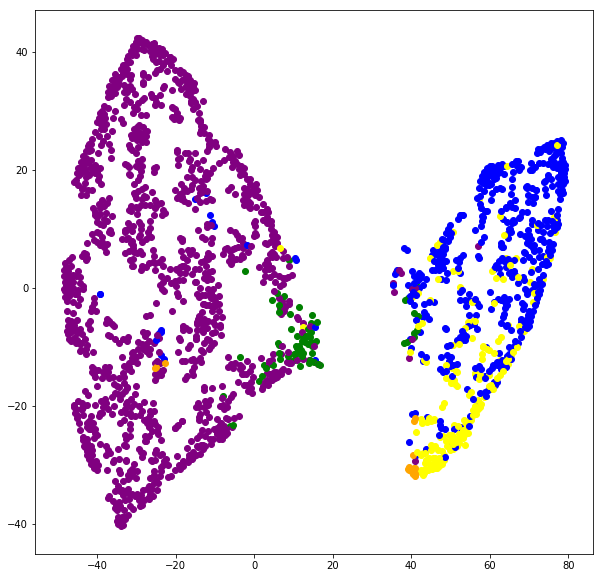

In [29]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights1[:,0],lowDWeights1[:,1],c=new_labels,cmap='jet')
plt.colorbar()
for i,label in enumerate(new_labels):
    x, y = lowDWeights1[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




MAX


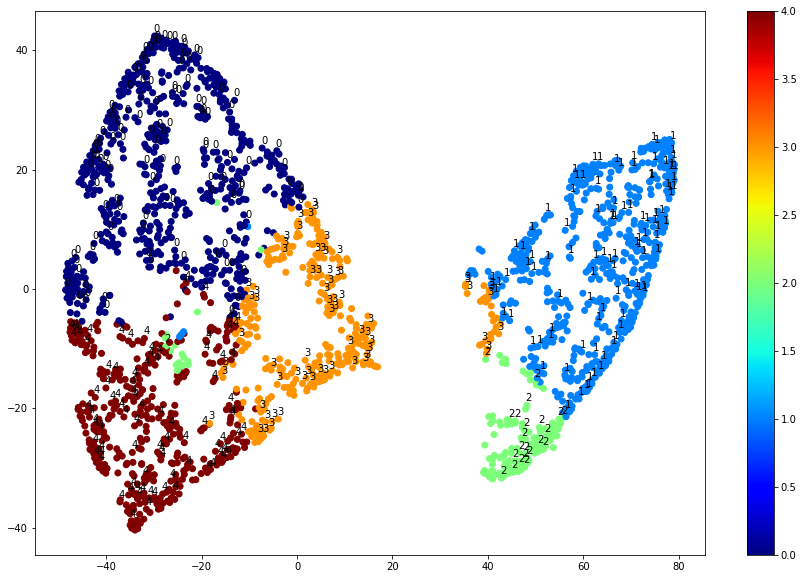

In [25]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels3,cmap='jet')
plt.colorbar()
for i,label in enumerate(labels3):
    x, y = lowDWeights2[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')



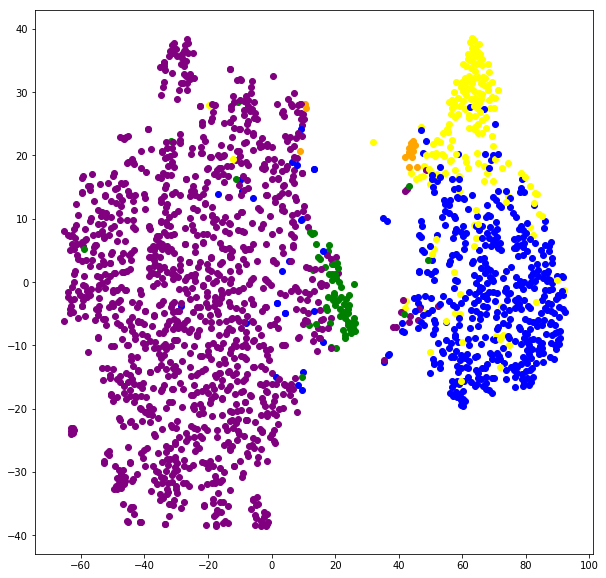

In [173]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=new_labels,cmap='jet')
plt.colorbar()
for i,label in enumerate(new_labels):
    x, y = lowDWeights2[i,:]
    if(i%5 == 0):
        plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')





AVERAGE


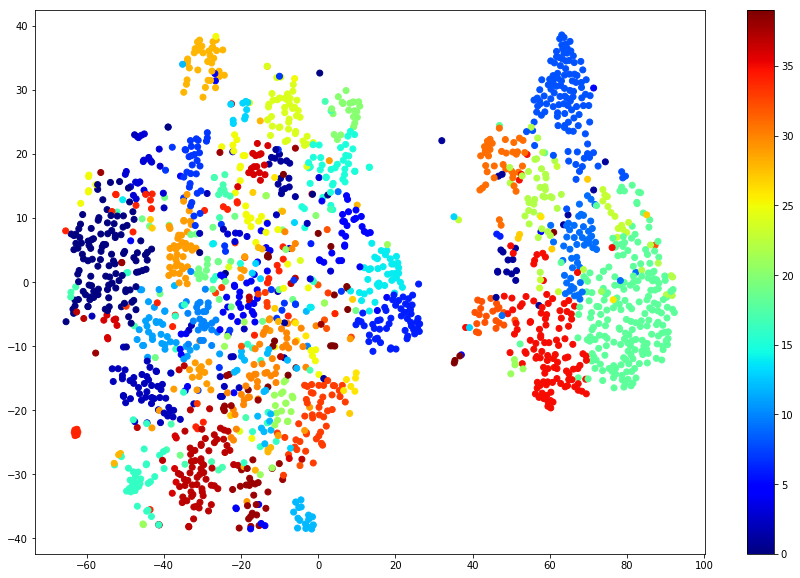

In [175]:
plt.figure(figsize=(15, 10))
plt.scatter(lowDWeights2[:,0],lowDWeights2[:,1],c=labels3,cmap='jet')
plt.colorbar()
for i,label in enumerate(labels3):
    x, y = lowDWeights2[i,:]
    if(i%5 == 0):
       plt.annotate(label,xy=(x,y),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')




** The following code allows for easy sampling and viewing from the produced topics **

525
[488  21 411  19  61 241 470 356 216 204 431 151 369 239 196 289 108 498
 316 407]


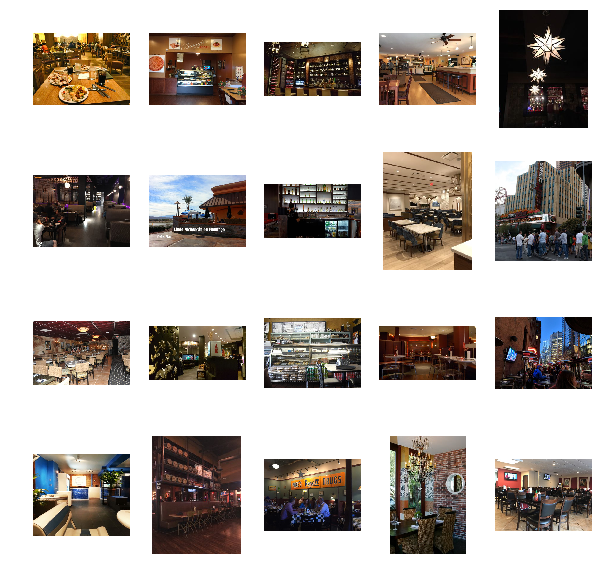

In [45]:
category = 1
model = model_lda_b5_av_topic_c_5
cat_ind = (np.argmax(model,axis=1) == category)
num_in_class = class_count[category]
print(num_in_class)
if(num_in_class < 20):
    num_images = num_in_class
else:
    num_images = 20
with matplotlib.rc_context({'figure.figsize': [10,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    val = np.random.choice(range(0,num_in_class),size=(num_images),replace=False)
    print(val)
    for i,num in enumerate(range(0,num_images)):
        cat_names = names_subset[cat_ind] 
        img = PIL.Image.open(cat_names[val[i]])
        plt.subplot(4,5,i+1)
        plt.axis('off')
        plt.imshow(img)
        

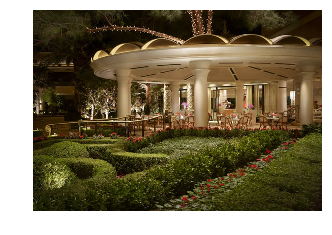

In [46]:
# The image can be looking at in more detail using the printed index from the previous code snipper
with matplotlib.rc_context({'figure.figsize': [30,25], 'axes.titlesize': 10}):
    fig = plt.figure()
    img = PIL.Image.open(names_subset[cat_ind][47])
    plt.subplot(4,5,i+1)
    plt.axis('off')
    plt.imshow(img)

** This code snippet can print any image from all 2000 images using its index **

3


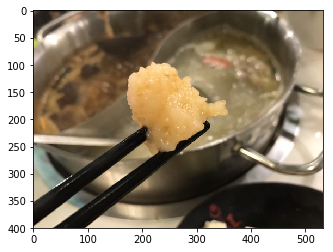

In [48]:
model_lda_b5_av_topic_c_5
img = PIL.Image.open(names_subset[image_num])
plt.imshow(img)
class_val = np.argmax(model[image_num,:])
print(class_val)

** This code snippet can be used to produce a heatmap of predictive probabilities for the chosen LDA model **

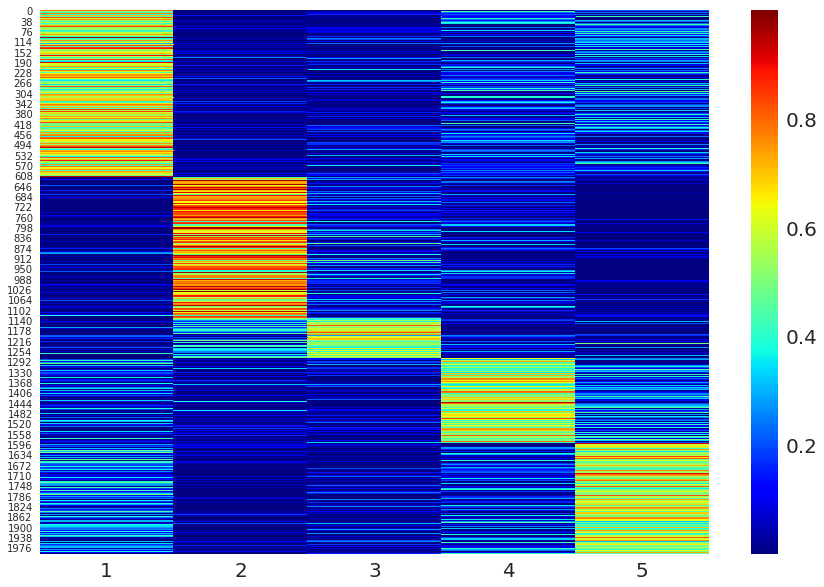

In [52]:
sns.set()
topic_ordered = np.argsort(np.argmax(model,axis=1))
with matplotlib.rc_context({'figure.figsize': [15,10], 'axes.titlesize': 10}):
    fig = plt.figure()
    ax = sns.heatmap(model[topic_ordered,:],cmap="jet")
    cax = plt.gcf().axes[-1]
    ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
    cax.tick_params(labelsize=20)
    plt.xticks(fontsize=20)